## Projects:

- Diffusion Models;
- YOLO versions  - object detection;
- Segment Anything Model (https://segment-anything.com/) (Liked);
- Mathematical Integration;
- BERT fine-tuning - Text classification (compare with logistic regression and TF-IDF vectors);
- CNN visualization - review the different techniques used to analyze CNN predictions;
- Monte Carlo dropout - review briefly the concept of uncertainty and what are the main techniques used to deal with uncertainty in deep learning;
- Deep vs Wide Neural Networks - Try to understand the effect of adding layers or adding parameters in a layer;
- Overparameterization regime;
- Neural ODEs - Neural Networks and ordinary differential equations are the two main modelization techniques used nowadays, review papers explaining some evolution of the idea of Neural ODE.

General observations:

- Presentation of 15 min 
- 70% grade
- No need to submit the code

Evaluation aspects:

- Clarity
- Understanding of concepts
- Depth of research and/or experiments

In [46]:
factorial = 1
n = int(input("Enter a number: "))
for i in range(1, n+1):
    factorial *= i
    print(i, factorial)
print("Factorial of", n, "is", factorial)

1 1
2 2
3 6
4 24
5 120
Factorial of 5 is 120


### Detect Text Regions Using OpenCV & OCR (Tesseract)

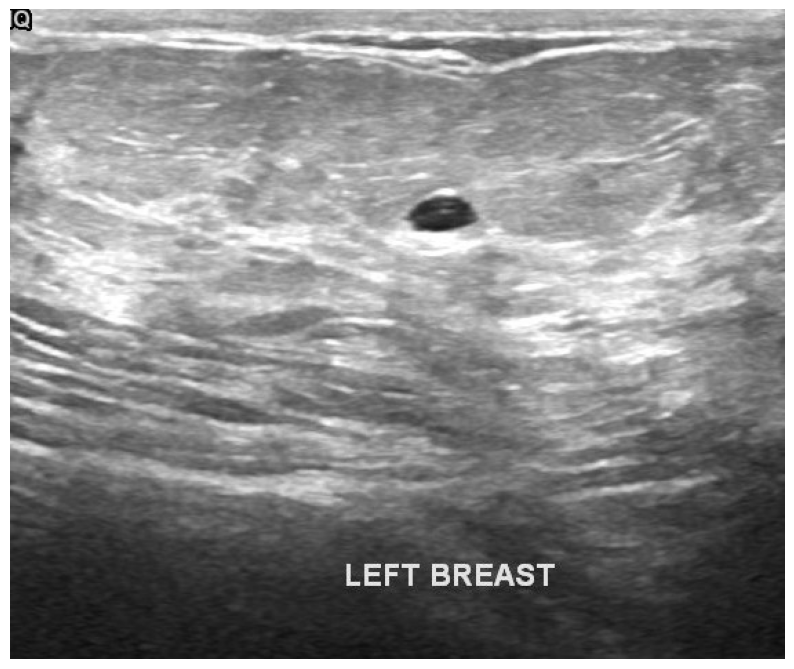

TesseractError: (1, 'Error opening data file /home/sobottka/anaconda3/envs/DL/share/tessdata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'eng\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [ ]:
import cv2
import pytesseract
import numpy as np

def remove_text(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply threshold to highlight text
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Use OCR to detect text boxes
    boxes = pytesseract.image_to_data(thresh, output_type=pytesseract.Output.DICT)
    
    # Create mask to cover detected text
    mask = np.ones_like(image) * 255  # White mask
    for i in range(len(boxes['text'])):
        if int(boxes['conf'][i]) > 60:  # Confidence threshold
            x, y, w, h = boxes['left'][i], boxes['top'][i], boxes['width'][i], boxes['height'][i]
            cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Black box to hide text

    # Apply inpainting to remove text
    inpainted_image = cv2.inpaint(image, cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), 5, cv2.INPAINT_TELEA)
    return inpainted_image

# Path to dataset
dataset_path = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images/"

# Load an example ultrasound image (Benign case)
image_path = os.path.join(dataset_path, "benign/benign (1).png")
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove text before segmentation
preprocessed_image = remove_text(image_rgb)

# Save or use the cleaned image
cv2.imwrite("cleaned_ultrasound.png", cv2.cvtColor(preprocessed_image, cv2.COLOR_RGB2BGR))


## Segmenting original image

In [34]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)

# Path to dataset
dataset_path = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images/"

# Load an example ultrasound image (Benign case)
image_path = os.path.join(dataset_path, "benign/benign (1).png")
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



/home/sobottka/anaconda3/envs/DL/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
#Stacking Masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [36]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [37]:
masks = mask_generator.generate(image_rgb)

In [38]:
print(len(masks))
print(masks[0].keys())

36
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


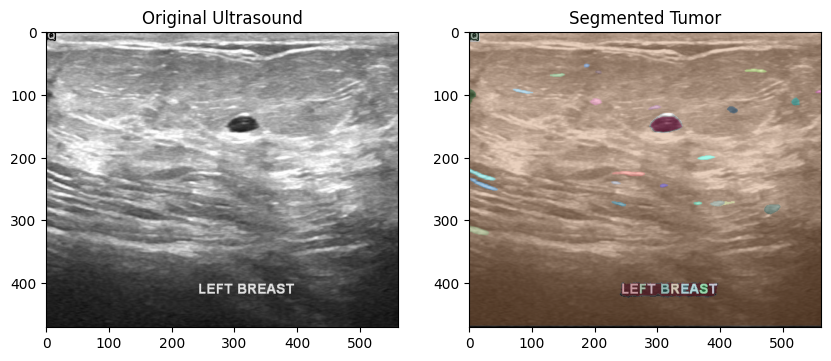

In [39]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Ultrasound")
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
show_anns(masks)
plt.title("Segmented Tumor")
plt.show()

## Saving Cropped image

In [40]:
#Creating directory for saving cropped regions
save_path = "./cropped_segments/"  # Folder to save cropped regions
os.makedirs(save_path, exist_ok=True)


In [41]:
# Function to extract and save each mask as a new image
def save_cropped_regions(image, masks, save_dir):
    for i, ann in enumerate(masks):
        mask = ann['segmentation']
        
        # Find bounding box
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip empty masks

        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Crop and save
        cropped_region = image[y_min:y_max, x_min:x_max]
        save_name = os.path.join(save_dir, f"segment_{i}.png")
        cv2.imwrite(save_name, cv2.cvtColor(cropped_region, cv2.COLOR_RGB2BGR))

save_cropped_regions(image_rgb, masks, save_path)
print(f"Cropped regions saved in: {save_path}")

Cropped regions saved in: ./cropped_segments/


## Training Classifier (Benign, Malignant, Normal)

#### Datase Preparation (PyTorch)

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define dataset class
class BreastTumorDataset(Dataset):
    def __init__(self, image_dir, labels, transform=None):
        self.image_dir = image_dir
        self.labels = labels  # Dictionary {filename: class_label}
        self.transform = transform
        self.image_list = list(labels.keys())

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        label = self.labels[img_name]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNN input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Example label dictionary (should come from a CSV or manual labeling)
labels_dict = {
    "segment_0.png": 0,  # 0 = Normal
    "segment_1.png": 1,  # 1 = Benign
    "segment_2.png": 2,  # 2 = Malignant
}

# Load dataset
dataset = BreastTumorDataset(save_path, labels_dict, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


#### CNN Model for Classification (Training)

In [ ]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18
class TumorClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TumorClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.model(x)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "tumor_classifier.pth")
print("Model saved!")


#### Running Classification on New Images

In [ ]:
def predict_tumor(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).item()

    classes = {0: "Normal", 1: "Benign", 2: "Malignant"}
    return classes[prediction]

# Load trained model
model = TumorClassifier()
model.load_state_dict(torch.load("tumor_classifier.pth"))
model.to(device)

# Predict
test_image_path = "./cropped_segments/segment_0.png"
predicted_label = predict_tumor(test_image_path, model, transform, device)
print(f"Predicted tumor type: {predicted_label}")
